# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Оглавление

* [Цели и задачи исследования](#research_purpose)
* [Знакомство с данными](#info)
* [Предобработка данных](#preprocessing)
    * [Работа с пропусками](#dropna)
    * [Преобразование типов данных](#dtype)
    * [Неявные дубликаты](#duplicates)
    * [Поиск аномалий](#anomal)
* [Добавление новых столбцов](#new_columns)
    * [Цена 1 квадратного метра](#price_per_m2)
    * [День недели, месяц и год публикации объявления](#dates)
    * [Тип этажа квартиры](#floor_type)
    * [Расстояние до центра города](#centre_distance)
* [Исследовательский анализ данных](#research)
    * [Изучение отдельных параметров](#params_research)
    * [Анализ скорости продажи квартир](#selling_speed)
    * [Факторы, влияющие на цену квартиры](#price_factors)
    * [Цена 1 квадратного метра в разных населенных пунктах](#price_per_m2_in_different_places)
    * [Влияние удаленности от центра на стоимость квартир](#centre_distance_influence)
* [Общий вывод](#conclusion)

**Цель и задачи исследования** <a class='anchor' id='research_purpose'></a>

Целью настоящей работы является определение факторов, влияющих на цены квартир в Санкт-Петербурге и Ленинградской области, а также оценка динамики продаж.

Для достижения цели в работе решаются следующие задачи:
- Предобработка данных для минимизации количества пропусков, удаления дубликатов, приведения данных к нужному типу и выявления аномалий;
- Определение цены квадратного метра и ее изменения в зависимости от населенного пункта и удаленности от центра города;
- Определение цены 1 км до центра города для квартир, находящихся в Санкт-Петербурге;
- Определение наиболее быстрых и медленных продаж;
- Корреляционный анализ для установки взаимосвязей между ценой квартиры и другими факторами.

### Открем файл с данными и изучим общую информацию. <a class='anchor' id='info'></a>

Импортируем необходимые библиотеки

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np

Сохраним файл с данными в переменную `data` и откроем его первые 5 строк

In [14]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Уже видны первые проблемы: пропуски в столбцах с данными. Посмотрим общую информацию о датасете с использованием метода `info()`. 

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Видим, что датасет содержит 23699 строк, причем пропуски характерны для многих столбцов. Также отметим, что дата публикации имеет тип данных `object`. В ходе предобработки нужно будет перевести в `datetime`. Также столбец `is_apartment`, где должны храниться данные булева типа, имеет тип данных `object`. Это тоже нужно исправить.  

Оценим количество явных дубликатов.

In [16]:
data.duplicated().sum()

0

В датасете отсутствуют явные дубликаты. Однако неисключено, что причиной этому могут быть одинаковые текстовые данные с разным регистром или близкие по смыслу названия. Разберемся с этим в разделе по предобработке данных.

Построим гистограммы для всех числовых столбцов датасета.

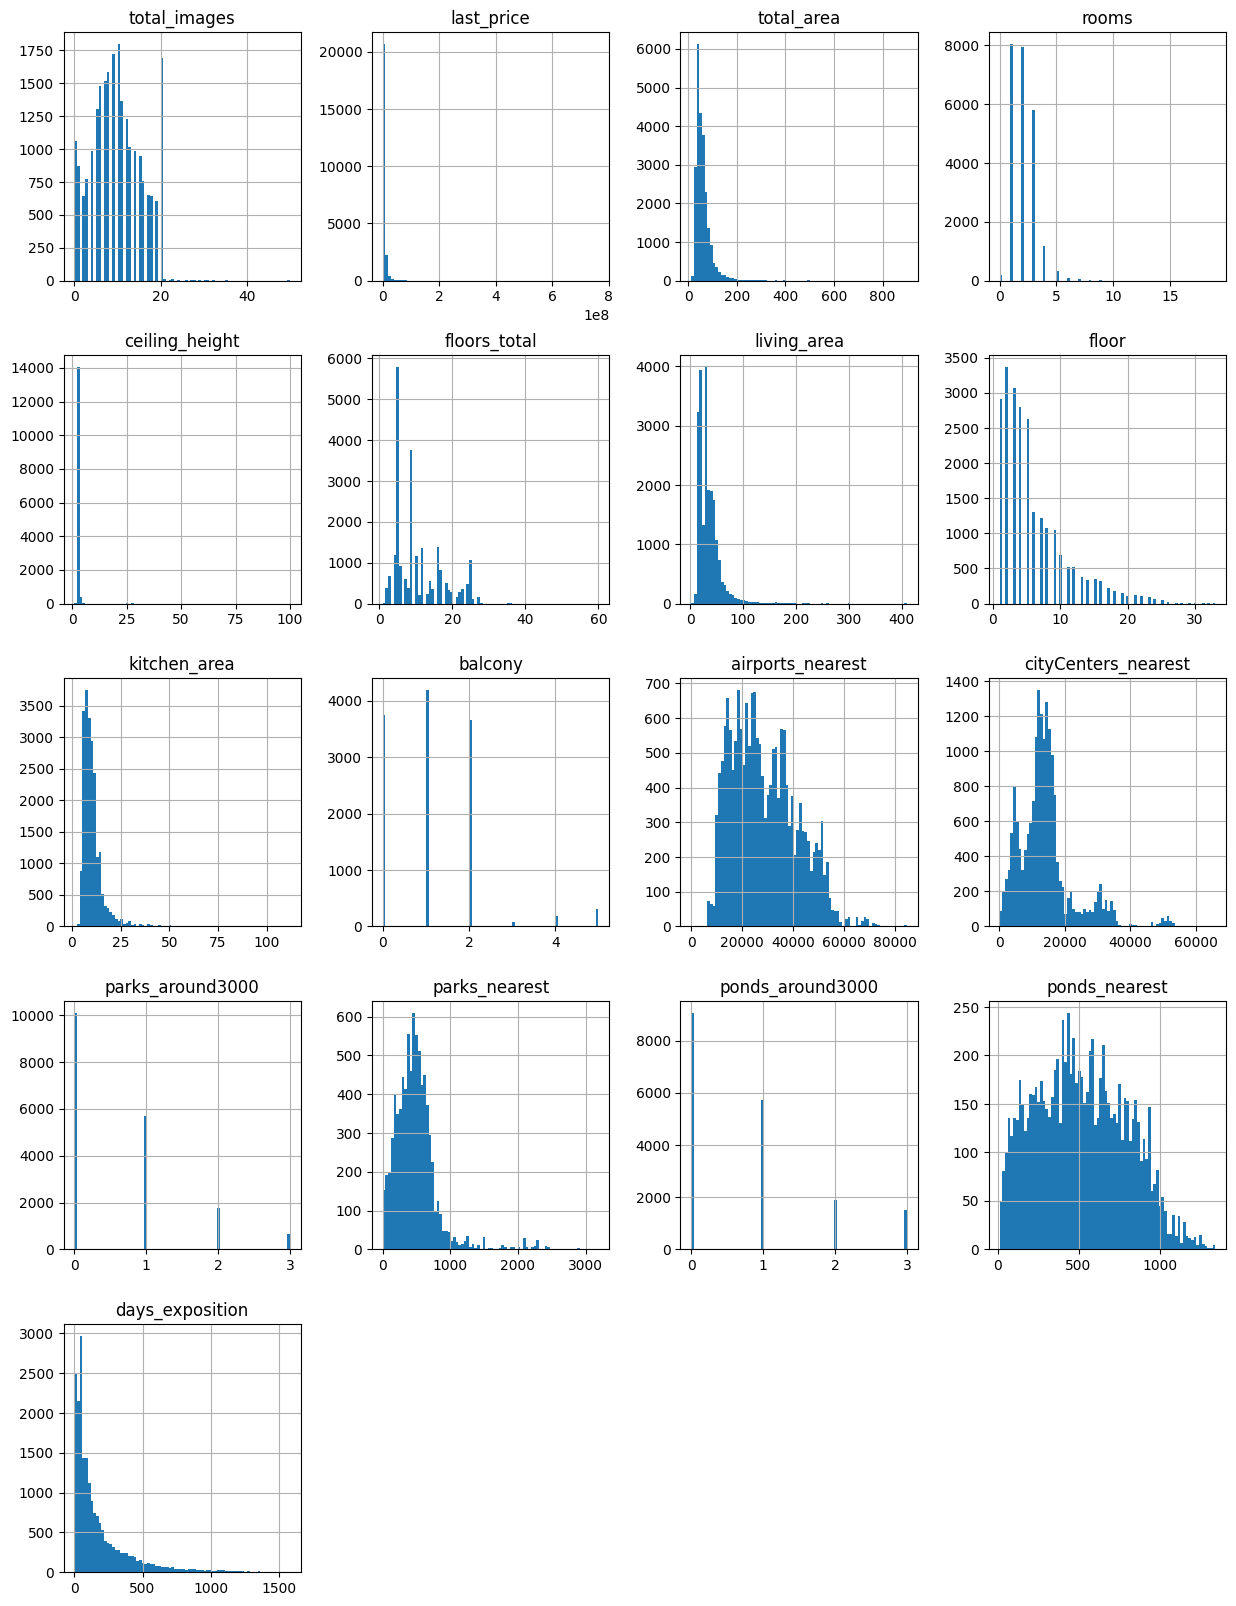

In [17]:
data.hist(bins=80, figsize=(15, 20));

Исходя из представленных гистограмм, можно сделать следующие предварительные выводы:

- Распределение числа фотографий квартир близко к нормальному - с максимумом в 10 фото. Присутствуют выбросы: более 20 фото, - и неожиданные всплески при 20 фото и в районе 0 фото. Нужно изучить природу выбросов и всплесков.
- Распределение цен перед снятием с публикации похоже на распределение Пуассона. Наблюдается преобладание дешевых квартир. **Нужно изучить это распределение отдельно с заданными границами.**
- Площадь квартир, вероятно, подчиняется нормальному рапределению. Присутствует хвост: квартиры площадью больше 100 м2. 
- В основном на продажу выставляют одно-, двух- и трехкомнатные квартиры.
- Распределение высоты потолков неинформативно. **Нужно рассмотреть отдельно с заданными границами.**
- Квартиры продают в домах с различным числом этажей. Распределение является полимодальным. 
- Распределение по жилой площади имеет 3 максимума и смещено в область менее 50 м2.
- Есть 2 группы квартир в зависимости от этажа, на котором они находятся: ниже 5 и выше 5. Преобладают квартиры на более низких этажах.
- Площадь кухонь распределена близко к нормальному. Присутствует хвост от 25 до 50 м2, что сопоставимо с общей площадью некоторых квартир. Выглядит странно.
- В основном продают квартиры с 1 балконом.
- Можно выделить 3 группы квартир по расстоянию до ближайшего аэропорта: 10-30 км; 30-40 км и 40-60 км.
- Преобладают квартиры с расстоянием до центра города около 15 км. Также есть группа квартир, находящихся ближе к центру - 5 км.
- В основном около квартир нет парков в пределах 3 км. А там, где парки есть, они находятся в пределах 500 м.
- Преобладают квартиры с водоемом в пределах 500 м. Очевидно, эти водоемы находятся в парках. 
- Объявления были размещены в соответствии с распределением Пуассона. Преобладают объявления со сроком размещения 0 - 175 дней.

Рассмотрим распределение цен перед снятием с публикации.

<Axes: >

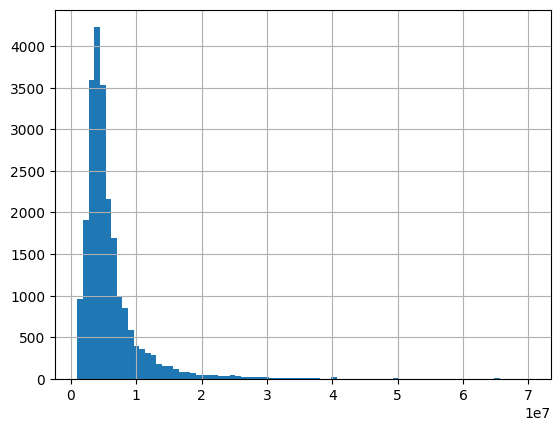

In [18]:
data['last_price'].hist(bins=80, range=(1000000, 70000000))

Видно, что преобладают квартиры дешевле 10 млн руб.

Рассмотрим распределение высоты потолков.

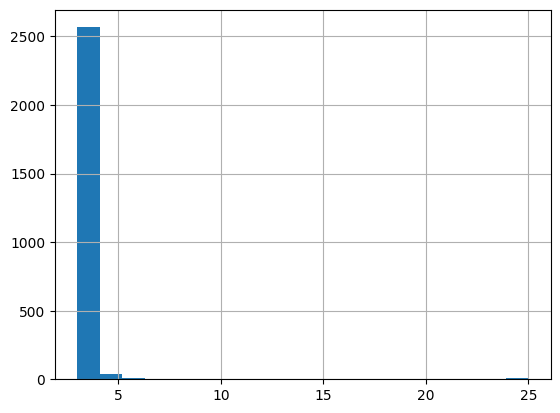

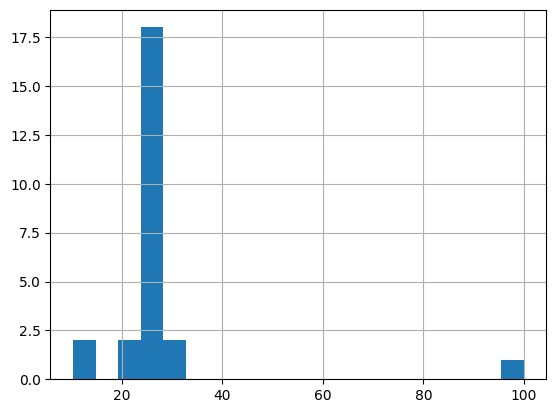

In [19]:
data['ceiling_height'].hist(bins=20, range=(3, 25))
plt.show()
data.query('ceiling_height > 10')['ceiling_height'].hist(bins=20)
plt.show()

Можно заметить, что в основном продают квартиры с потолками от 3 до 3.5 м. Есть выбросы около 8, 25 м.

При более детальном рассмотрении видно, что присутствуют квартиры с чересчур высокими потолками: 20 и более метров. Вероятно, это опечатки, и высоты должны быть уменьшены в 10 раз, чтобы выглядело правдоподобно. **Сделаем это при предобработке данных.**

### Предобработка данных <a class='anchor' id='preprocessing'></a>

#### Работа с пропусками <a class='anchor' id='dropna'></a>

Определим столбцы, в которых содержатся пропуски.

In [20]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

***Высота потолков***

В столбце с данными о высоте потолков присутствует 9195 пропусков, что составляет порядка 39% от общего количества строк. Удалить эти данные нельзя, т.к. это значительно уменьшит размер анализируемого массива. Эти данные, скорее всего, случайно пропущены. Оставим пропуски в этом столбце.

***Количество этажей в доме***

В столбце с данными о количестве этажей в доме всего 86 пропусков. Это меньше 1% от общего числа строк в датасете. Посмотрим на несколько таких строк.

In [21]:
data[data['floors_total'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,NaN,NaN,30.80,4,NaN,False,False,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,NaN,NaN,20.75,1,NaN,False,False,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,NaN,NaN,38.40,12,NaN,False,False,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,NaN,NaN,47.10,8,NaN,False,False,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,NaN,NaN,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0


Видим, что во всех случаях указан этаж, где находится квартира. Значит, число этажей в доме просто случайно пропустили. Оставим данные пропуски.

***Жилая площадь***

В данных о жилой площади наблюдается 1903 пропуска (порядка 8%). Выведем некоторые из этих строк.

In [22]:
data[data['living_area'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,NaN,9.0,NaN,2,NaN,False,False,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.5,5.0,NaN,1,NaN,False,False,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,NaN,22.0,NaN,3,NaN,False,False,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN


Вероятно, данные о жил. площади пропущены случайно. Пропусков не более 8% от общего числа строк. Заполним их медианным значением жил. площади для квартир с таким же числом комнат.

In [23]:
for rooms in data['rooms'].unique():
    data.loc[(data['rooms'] == rooms) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[data['rooms'] == rooms, 'living_area'].median()
data['living_area'].isna().sum() #проверяем, не осталось ли пропусков

0

***Апартаменты или нет?***

В столбце, где находится статус, является ли квартира жилой или это апартаменты, количество пропусков близко к 90%. Это крайне много. Эти пропуски определенно нельзя удалять.

Посмотрим, есть ли квартиры, являющиеся апартаментами.

In [24]:
data[data['is_apartment'] == True]['is_apartment'].count()

50

Итак, у нас есть 50 апартаментов. Для остальных квартир, видимо, подразумевалось, что пропуски означают, что эти квартиры не являются апартаментами. Заполним такие пропуски значениями `False`.

In [25]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].isna().sum()

0

***Площадь кухни***

В столбце с данными о площади кухни 2278 пропусков. Поскольку кухни может не быть в планировке, но, по факту, она будет в квартире, оставим пропуски в этом столбце.

***Количество балконов***

Пропуски в столбце с количеством балконов, вероятно, связаны с тем, что в этих квартирах балконов просто нет. Заполним эти пропуски нулями.

In [26]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().sum()

0

***Название населенного пункта***

Пропусков в столбце с названиями населенных пунктов не так много. Скорее всего, просто забыли указать. Заполним пропуски строкой `неизвестно`.

In [27]:
data['locality_name'] = data['locality_name'].fillna('неизвестно')
data['locality_name'].isna().sum()

0

***Расстояние до ближайшего аэропорта***

Пропусков в столбце с данными о расстоянии до ближайшего аэропорта 5542. Связаны они, скорее всего, с отсутствием аэропорта в конкретных населенных пунктах. Посмотрим названия населенных пунктов, где есть пропуски.

In [28]:
data.loc[data['airports_nearest'].isna(), 'locality_name'].unique()

array(['городской посёлок Янино-1', 'посёлок Мурино', 'Сертолово',
       'деревня Кудрово', 'Коммунар',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кировск',
       'деревня Новое Девяткино', 'Санкт-Петербург',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'деревня Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск',
       'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Сясьстрой', 'деревня Старая', 'деревня Лесколово',
       'посёлок Новый Свет', 'Сланцы', 'село Путилово', 'Ивангород',
       'Мурино', 'Шлиссельбург', 'Никольское', 'Сосновый Бор',
       'поселок Новый Свет', 'деревня Оржицы', 'деревня Кальтино',
 

Видим, что основную массу населенных пунктов, где не указано расстояние до ближайшего аэропорта, составляют деревни, села и поселки. В указанных населенных пунктах просто нет аэропорта. Странно, что в этот список попали квартиры из Санкт-Петербурга. Видимо, случайно. Оставим пропуски в данном столбце. 

***Расстояние до центра города***

5519 пропусков присутствуют в данных о расстоянии до центра города. Посмотрим, в каких населенных пунктах находятся эти квартиры.

In [29]:
data[data['cityCenters_nearest'].isna()]['locality_name'].unique()

array(['городской посёлок Янино-1', 'посёлок Мурино', 'Сертолово',
       'деревня Кудрово', 'Коммунар',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кировск',
       'деревня Новое Девяткино', 'Санкт-Петербург',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'деревня Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск',
       'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Сясьстрой', 'деревня Старая', 'деревня Лесколово',
       'посёлок Новый Свет', 'Сланцы', 'село Путилово', 'Ивангород',
       'Мурино', 'Шлиссельбург', 'Никольское', 'Сосновый Бор',
       'поселок Новый Свет', 'деревня Оржицы', 'деревня Кальтино',
 

В числе населенных пунктов есть города: Санкт-Петербург, Кировск, Выборг, Всеволожск, Мурино, Волхов и т.д. Для квартир в городах должны были быть данные о расстоянии до центра города. Вероятно, пропуски в данном случае случайны. А те квартиры, что находятся в деревнях, селах и поселках, центра города не имеют вовсе. Оставим пропуски во всех случаях.

***Парки в радиусе 3 км***

Пропуски в данных о количестве парков в радиусе 3 км могут быть связаны с тем, что парков в этой зоне просто нет. Заполним такие пропуски нулями.

In [30]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_around3000'].isna().sum()

0

***Расстояние до ближайшего парка***

Порядка 60% пропусков содержится в данных о расстоянии до ближайшего парка. Возможно, в местах, где расположены эти квартиры, нет парков. Оставим эти пропуски нетронутыми.

***Пруды в радиусе 3 км***

Количество пропусков в данном столбце совпадает с этим показателем для столбца про парки в том же радиусе. Видимо, пруды находятся в парках. А раз парков поблизости нет, то и прудов - тоже. Заполним эти пропуски нулями. 

In [31]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_around3000'].isna().sum()

0

***Расстояние до ближайшего пруда***

По аналогии с парками оставим эти пропуски без заполнения.

***Сколько дней было размещено объявление***

Пропуски в рассматриваемом столбце могут быть связаны с тем, что объявление создано случайно или с ошибками и сразу закрыто. В то же время, объявление все еще может быть открыто, тогда логично, что нет данных о количестве дней размещения. Таких строк достаточно много, поэтому оставим эти пропуски. 

***Проверим количество пропусков во всех столбцах еще раз***

In [32]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

Все столбцы, где мы хотели заполнить пропуски, больше не содержат белых пятен. Перейдем к следующему шагу предобработки.

#### Преобразование типов данных <a class='anchor' id='dtype'></a>

Как мы уже отметили, данные в столбце с датами публикации имеют тип данных `object`. Нужно будет перевести в `datetime`. Также столбец `is_apartment`, где должны храниться данные булева типа, имеет тип данных `object`. Это тоже нужно исправить. 

***Дата публикации***

In [33]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') #переводим дату в формат datetime
data.info() #проверяем результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

***Апартаменты***

In [34]:
data['is_apartment'] = data['is_apartment'].astype('bool') #переводим данные в булев тип
data.info() #проверяем результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

Данные в нужных столбцах приведены к правильному формату. Перейдем к следующему шагу предобработки. 

#### Неявные дубликаты <a class='anchor' id='duplicates'></a>

Как мы уже выяснили на этапе знакомства с датасетом, явные дубликаты отсутствуют. Однако могут быть неявные: одно и то же название с разным регистром; буквы `е` и `ё`; описание одного и того же объекта разными словами. Проверка коснется столбца с текстовыми названиями населенных пунктов.

In [35]:
data['locality_name'].unique() #посмотрим уникальные названия населенных пунктов

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Видно, что есть следующие неявные дубликаты:
- "поселок Рябово" и "поселок городского типа Рябово"; 
- "поселок Тельмана" и "посёлок Тельмана";
- "городской посёлок Янино-1" и "городской поселок Янино-1";
- "посёлок Мурино", "поселок Мурино" и "Мурино";
- "деревня Кудрово" и "Кудрово";
- "поселок городского типа Красный Бор" и "посёлок городского типа Красный Бор";
- "посёлок городского типа Лебяжье" и "поселок городского типа Лебяжье";
- "поселок городского типа Кузьмоловский" и "посёлок городского типа Кузьмоловский";
- "посёлок Аннино" и "поселок Аннино";
- "поселок Старая Малукса" и "посёлок Старая Малукса";
- "посёлок Новый Свет" и "поселок Новый Свет";
- "поселок Бугры" и "посёлок Бугры";
- "поселок городского типа Рощино"; "посёлок городского типа Рощино" и "городской посёлок Рощино";
- "посёлок Усть-Луга" и "поселок Усть-Луга";
- "городской посёлок Павлово" и "посёлок городского типа Павлово";
- "посёлок Победа" и "поселок Победа";
- "поселок Терволово" и "посёлок Терволово";
- "поселок городского типа Советский" и "городской посёлок Советский";
- "посёлок Петровское" и "поселок Петровское";
- "посёлок городского типа Токсово" и "поселок городского типа Токсово";
- "посёлок городского типа Вырица" и "поселок городского типа Вырица";
- "городской поселок Большая Ижора" и "поселок городского типа Большая Ижора";
- "городской посёлок Лесогорский" и "поселок городского типа Лесогорский";
- "поселок городского типа имени Свердлова" и "посёлок городского типа имени Свердлова";
- "посёлок Поляны" и "поселок Поляны";
- "городской посёлок Мга" и "посёлок городского типа Мга";
- "посёлок Мичуринское" и "поселок Мичуринское";
- "поселок Ильичёво" и "посёлок Ильичёво";
- "поселок станции Вещево" и "посёлок при железнодорожной станции Вещево";
- "посёлок Гаврилово" и "поселок Гаврилово";
- "городской посёлок Назия" и "поселок городского типа Назия";
- "поселок станции Приветнинское" и "посёлок при железнодорожной станции Приветнинское";
- "поселок Мельниково" и "посёлок Мельниково";
- "Любань" и "поселок Любань";
- "Никольское" и "село Никольское";
- "поселок Стеклянный" и "посёлок Стеклянный";
- "поселок городского типа Форносово" и "посёлок городского типа Форносово";
- "посёлок Сумино" и "поселок Сумино";
- "посёлок Возрождение" и "поселок Возрождение";
- "поселок Лисий Нос" и "посёлок Лисий Нос";
- "поселок Жилгородок" и "посёлок Жилгородок";
- "посёлок станции Громово" и "поселок Громово";
- "посёлок Коробицыно" и "поселок Коробицыно";
- "посёлок Кобралово" и "поселок Кобралово";
- "поселок Лесное" и "коттеджный посёлок Лесное";
- "поселок Перово" и "посёлок Перово";
- "посёлок Пансионат Зелёный Бор" и "поселок Пансионат Зелёный Бор".

Всего имеем 47 неявных дубликатов. Заменим их, чтобы было единообразие в названиях населенных пунктов.

In [36]:
data['locality_name'].nunique() #считаем первоначальное количество уникальных названий населенных пунктов

365

In [37]:
replacements = {
    'поселок городского типа Рябово': 'поселок Рябово',
    'посёлок Тельмана': 'поселок Тельмана',
    'городской посёлок Янино-1': 'городской поселок Янино-1',
    'посёлок Мурино': 'Мурино',
    'поселок Мурино': 'Мурино',
    'деревня Кудрово': 'Кудрово',
    'посёлок городского типа Красный Бор': 'поселок городского типа Красный Бор',
    'посёлок городского типа Лебяжье': 'поселок городского типа Лебяжье',
    'посёлок городского типа Кузьмоловский': 'поселок городского типа Кузьмоловский',
    'посёлок Аннино': 'поселок Аннино',
    'посёлок Старая Малукса': 'поселок Старая Малукса',
    'посёлок Новый Свет': 'поселок Новый Свет',
    'посёлок Бугры': 'поселок Бугры',
    'посёлок городского типа Рощино': 'поселок городского типа Рощино',
    'городской посёлок Рощино': 'поселок городского типа Рощино',
    'посёлок Усть-Луга': 'поселок Усть-Луга',
    'городской посёлок Павлово': 'посёлок городского типа Павлово',
    'посёлок Победа': 'поселок Победа',
    'посёлок Терволово': 'поселок Терволово',
    'городской посёлок Советский': 'поселок городского типа Советский',
    'посёлок Петровское': 'поселок Петровское',
    'посёлок городского типа Токсово': 'поселок городского типа Токсово',
    'посёлок городского типа Вырица': 'поселок городского типа Вырица',
    'городской поселок Большая Ижора': 'поселок городского типа Большая Ижора',
    'городской посёлок Лесогорский': 'поселок городского типа Лесогорский',
    'посёлок городского типа имени Свердлова': 'поселок городского типа имени Свердлова',
    'посёлок Поляны': 'поселок Поляны',
    'городской посёлок Мга': 'посёлок городского типа Мга',
    'посёлок Мичуринское': 'поселок Мичуринское',
    'посёлок Ильичёво': 'поселок Ильичёво',
    'посёлок при железнодорожной станции Вещево': 'поселок станции Вещево',
    'посёлок Гаврилово': 'поселок Гаврилово',
    'городской посёлок Назия': 'поселок городского типа Назия',
    'посёлок при железнодорожной станции Приветнинское': 'поселок станции Приветнинское',
    'посёлок Мельниково': 'поселок Мельниково',
    'поселок Любань': 'Любань',
    'село Никольское': 'Никольское',
    'посёлок Стеклянный': 'поселок Стеклянный',
    'посёлок городского типа Форносово': 'поселок городского типа Форносово',
    'посёлок Сумино': 'поселок Сумино',
    'посёлок Возрождение': 'поселок Возрождение',
    'посёлок Лисий Нос': 'поселок Лисий Нос',
    'посёлок Жилгородок': 'поселок Жилгородок',
    'посёлок станции Громово': 'поселок Громово',
    'посёлок Коробицыно': 'поселок Коробицыно',
    'посёлок Кобралово': 'поселок Кобралово',
    'коттеджный посёлок Лесное': 'посёлок Лесное',
    'посёлок Перово': 'поселок Перово',
    'посёлок Пансионат Зелёный Бор': 'поселок Пансионат Зелёный Бор'
}
data['locality_name'] = data['locality_name'].map(replacements).fillna(data['locality_name'])
data['locality_name'].nunique() #считаем новое количество уникальных названий

317

Все неявные дубликаты успешно заменены. Перейдем к следующему шагу предобработки.

#### Поиск аномалий <a class='anchor' id='anomal'></a>

***Высота потолков***

При первичном знакомстве с данными сразу удалось увидеть аномально высокие потолки в ряде квартир: 20 м и более. Эти значения нужно уменьшить в 10 раз, чтобы были получены корректные величины.

In [38]:
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] = \
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] / 10
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'].value_counts()

Series([], Name: count, dtype: int64)

Аномальные высоты потолков больше 20 м пересчитаны. Тем не менее, есть еще потолки высотой более 5 м. 

In [39]:
data.loc[data['ceiling_height'] >= 5, 'ceiling_height']

464       5.2
1026      5.3
1053      5.0
1388      5.6
3474      8.0
5863      8.3
7578      5.5
12628     5.3
15061    14.0
15743     8.0
17442     8.0
20264     6.0
21227     5.8
22309    10.3
22869    10.0
Name: ceiling_height, dtype: float64

Тут уже нельзя просто так уменьшить в 10 раз. Потолки высотой 5 - 6 м возможны в старых либо двухуровневых квартирах. А вот все, что превышает 8 м выглядит не очень правдоподобно. Удалим все квартиры с высотой потолка более 8 м.

In [40]:
data = data[~(data['ceiling_height'] >= 8)]
data.loc[data['ceiling_height'] >= 8, 'ceiling_height'].value_counts()

Series([], Name: count, dtype: int64)

Посмотрим на распределение квартир по высотам потолков еще раз.

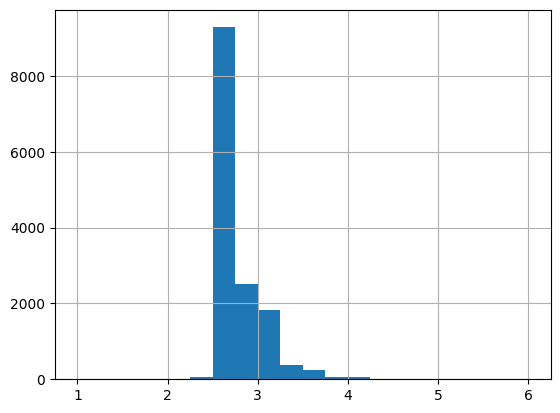

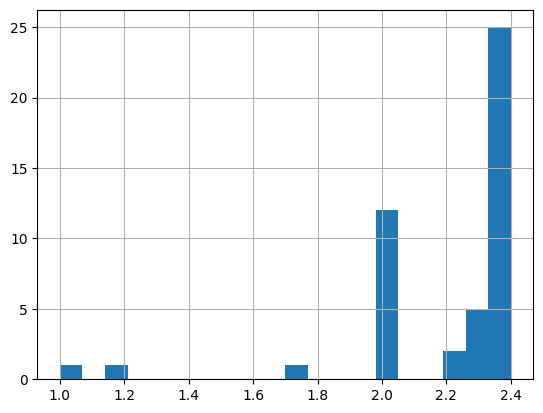

In [41]:
data['ceiling_height'].hist(bins=20)
plt.show()
data['ceiling_height'].hist(bins=20, range=(1, 2.4))
plt.show()

Аномально высокие потолки убрали. Но есть еще и аномально низкие - менее 2.5 м. По ГОСТ для жилых помещений потолки должны быть высотой не менее 2.5 м, поэтому удалим все строки, не удовлетворяющие этому условию.

<Axes: >

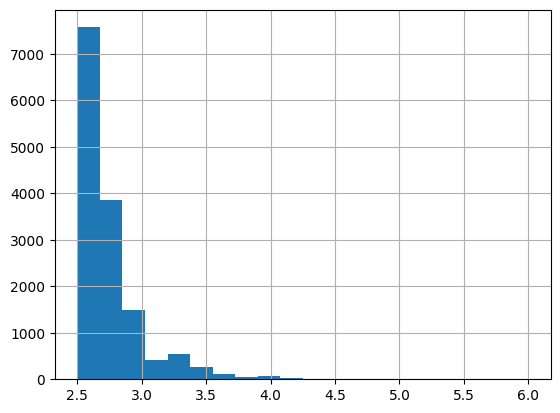

In [42]:
data = data[~(data['ceiling_height'] < 2.5)]
data['ceiling_height'].hist(bins=20)

Теперь распределение высот потолков выглядит более реалистично и похоже на Пуассоново. 

***Площадь квартир***

Для всех квартир указана общая и жилая площадь, а также площадь кухни. Логично проверить, во всех ли случаях общая площадь больше суммы жилой площади и площади кухни.

In [43]:
# Создаем столбец с логическими значениями. Если неравенство по площади выполняется, то получим True, в противном случае - False
data['area_check'] = data['total_area'] < data['kitchen_area'] + data['living_area'] 
data['area_check']

0        False
1        False
2        False
3        False
4        False
         ...  
23694    False
23695    False
23696    False
23697    False
23698    False
Name: area_check, Length: 23616, dtype: bool

Сразу видны некоторые строки, где условие не выполняется. Посчитаем количество таких квартир.

In [44]:
data['area_check'].sum()

73

Для найденных квартир, явно указаны некорреткные значения площади. Это существенно, ведь мы планируем рассчитывать цену 1 м2. Избавимся сразу от таких строк, чтобы не искажать результаты.

In [45]:
data = data[data['area_check'] == False]
data['area_check'].sum()

0

Квартиры с аномальными значениями площади успешно удалены.

***Этажи***

Проверим, нет ли квартир, для которых указанный этаж превышает общее количество этажей в доме.

In [46]:
data['check_floor'] = data['floors_total'] < data['floor']
data['check_floor']

0        False
1        False
2        False
3        False
4        False
         ...  
23694    False
23695    False
23696    False
23697    False
23698    False
Name: check_floor, Length: 23543, dtype: bool

In [47]:
data['check_floor'].sum()

0

Квартир с некорректно указанными этажами, нет.

***Балконы и комнаты***

Посмотрим еще раз на распределение квартир по количеству балконов.

<Axes: >

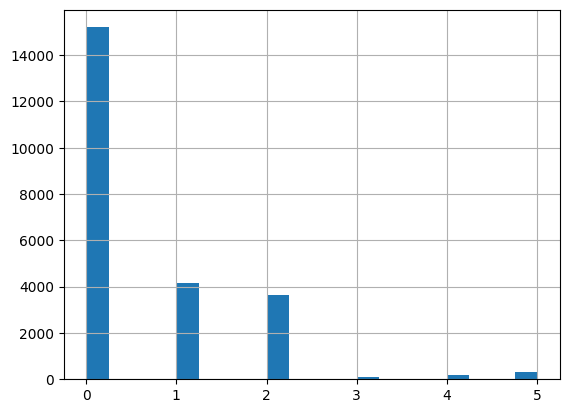

In [48]:
data['balcony'].hist(bins=20)

Квартиры, где есть 3 балкона - это редкость. Но 4 и 5 - выглядит странно. Это могут быть какие-то пентхаусы, конечно. Проверим, есть ли квартиры, где число балконов превышает число комнат.

In [49]:
data['balcony_check'] = data['balcony'] > data['rooms']
data['balcony_check'].sum()

2057

Имеем 2057 квартир, где число балконов превышает число комнат. Взглянем, сколько там балконов и какая там площадь.

In [50]:
(
    data[data['balcony_check']][['balcony', 'total_area']]
.groupby('balcony')
.agg('median')
.reset_index()
)

,balcony,total_area
0,1.0,26.00
1,2.0,38.20
2,3.0,58.00
3,4.0,67.10
4,5.0,70.85


Интересно. Есть квартиры, где комнат вообще нет и есть 1 балкон. Посмотрим, что это за квартиры.

In [51]:
data[(data['balcony_check']) & (data['balcony'] == 1)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_check,check_floor,balcony_check
508,0,3375000.0,34.40,2017-03-28,0,NaN,26.0,24.30,19,False,False,True,NaN,1.0,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0,False,False,True
780,9,2600000.0,26.10,2018-02-20,0,NaN,18.0,18.00,8,False,False,True,NaN,1.0,Мурино,NaN,NaN,0.0,NaN,0.0,NaN,45.0,False,False,True
839,14,1900000.0,35.00,2017-04-14,0,2.70,5.0,15.00,3,False,False,True,NaN,1.0,поселок Новый Свет,NaN,NaN,0.0,NaN,0.0,NaN,7.0,False,False,True
1574,0,2200000.0,22.00,2017-11-03,0,NaN,18.0,15.00,16,False,False,True,NaN,1.0,Кудрово,NaN,NaN,0.0,NaN,0.0,NaN,81.0,False,False,True
1625,7,1980000.0,23.98,2018-02-01,0,NaN,4.0,10.50,3,False,False,True,NaN,1.0,поселок станции Корнево,NaN,NaN,0.0,NaN,0.0,NaN,120.0,False,False,True
2166,6,2400000.0,23.00,2018-08-14,0,NaN,17.0,14.60,13,False,True,False,NaN,1.0,Мурино,NaN,NaN,0.0,NaN,0.0,NaN,28.0,False,False,True
2727,4,3670000.0,26.49,2018-07-26,0,2.60,21.0,19.00,4,False,True,False,NaN,1.0,Санкт-Петербург,36579.0,9092.0,0.0,NaN,1.0,454.0,28.0,False,False,True
6640,5,3000000.0,25.00,2018-03-01,0,2.75,17.0,18.00,13,False,True,False,NaN,1.0,Санкт-Петербург,18881.0,17734.0,0.0,NaN,2.0,210.0,56.0,False,False,True
6805,7,1850000.0,31.00,2017-11-10,0,NaN,18.0,18.00,10,False,False,True,NaN,1.0,Никольское,NaN,NaN,0.0,NaN,0.0,NaN,7.0,False,False,True
8721,9,3200000.0,26.00,2018-07-16,0,NaN,19.0,14.00,17,False,True,False,NaN,1.0,посёлок Шушары,11858.0,17411.0,0.0,NaN,0.0,NaN,266.0,False,False,True


Количество комнат в таких квартирах, действительно, равно нулю. При этом указана жилая площадь. Может быть, это студии. Проверим.

In [52]:
data[(data['balcony_check']) & (data['balcony'] == 1)]['studio']

508      False
780      False
839      False
1574     False
1625     False
2166      True
2727      True
6640      True
6805     False
8721      True
10284    False
10534     True
10606    False
11382     True
11705    False
12280     True
12691    False
15714     True
16093     True
16429    False
16521     True
17660     True
17695    False
18782    False
19154     True
20584     True
22200     True
22246     True
22391     True
Name: studio, dtype: bool

Есть случаи, когда в квартире нет комнат и это не студия. Очень странные строки. Лучше от них избавиться.

In [53]:
data = data[~((data['balcony_check']) & (data['balcony'] == 1) & (data['studio'] == False))]

С квартирами без комнат и 1 балконом разобрались. Квартиры, где 2 - 5 балконов, а комнат меньше, отличаются площадью, что логично. Но непонятным остается, почему же в них балконов больше, чем самих комнат. Впрочем, в рамках нашего исследования число балконов не играет роли, поэтому оставим эти строки, чтобы сохранить больше данных для анализа.

**Удалим аномалии в столбце с общей площадью**

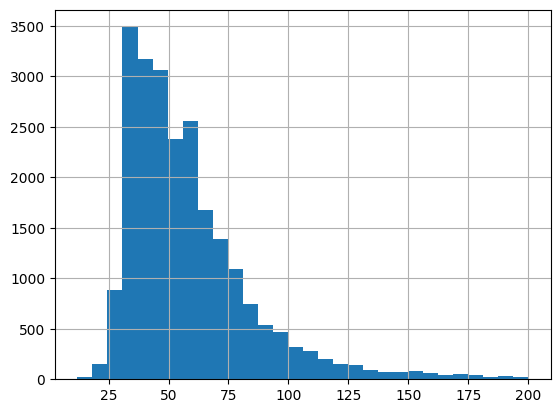

In [55]:
data = data[data['total_area'] <= 200]
data['total_area'].hist(bins=30);

**Удалим аномалии в столбце с ценой квартиры**

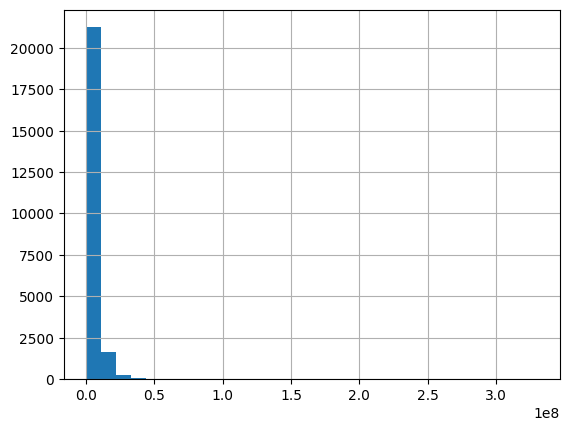

In [56]:
# Взглянем на гистограмму распределения цен
data['last_price'].hist(bins=30);

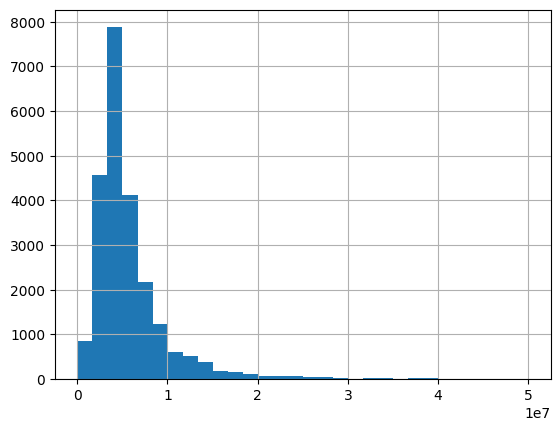

In [57]:
# Уберем данные больше 50 млн руб.
data = data[data['last_price'] <= 50000000]
data['last_price'].hist(bins=30);

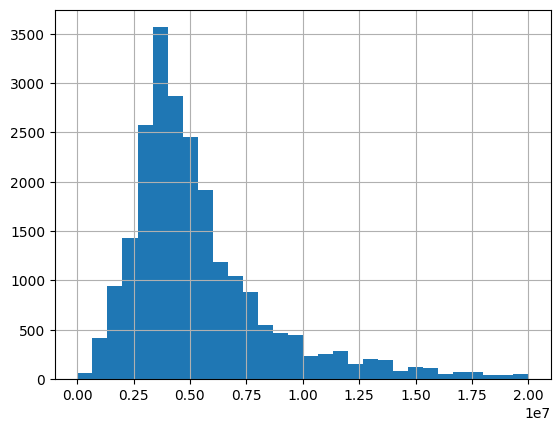

In [58]:
# Можно смело убрать и квартиры стоимостью больше 20 млн руб.
data = data[data['last_price'] <= 20000000]
data['last_price'].hist(bins=30);

**Удалим аномалии в столбце с количеством комнат**

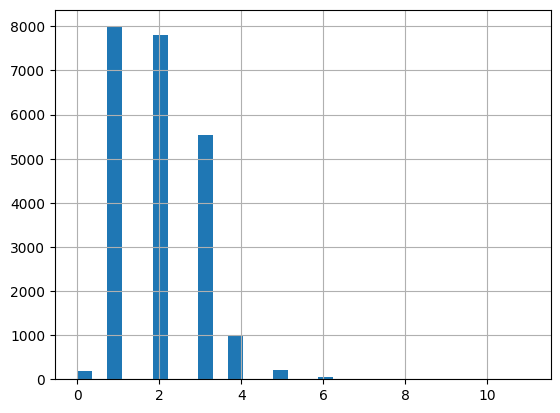

In [59]:
# Взглянем на гистограмму распределения числа комнат
data['rooms'].hist(bins=30);

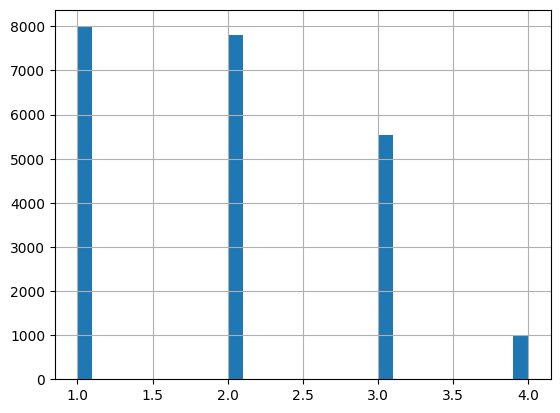

In [60]:
# Удалим из датасета квартиры более чем с 5 комнатами, а также без комнат вовсе.
data = data[(data['rooms'] <= 4) & (data['rooms'] != 0)]
data['rooms'].hist(bins=30);

### Посчитайте и добавьте в таблицу новые столбцы <a class='anchor' id='new_columns'></a>

#### Цена 1 квадратного метра <a class='anchor' id='price_per_m2'></a>

Для расчета этого показателя нужно поделить цену квартиры из столбца `last_price` на общую площадь в столбце `total_area`.

In [61]:
data['price_per_area'] = data['last_price'] / data['total_area']
data['price_per_area'].head()

0    120370.370370
1     82920.792079
2     92785.714286
4    100000.000000
5     95065.789474
Name: price_per_area, dtype: float64

#### День недели, месяц и год публикации объявления <a class='anchor' id='dates'></a>

Для определения дня недели, месяца и года по дате публикации объявления в столбце `first_day_exposition` нужно воспользоваться методом `dt`.

In [62]:
# Определяем номер дня недели
data['first_exposition_day_of_week'] = data['first_day_exposition'].dt.weekday


# Определяем месяц
data['first_exposition_month'] = data['first_day_exposition'].dt.month

#Определяем год
data['first_exposition_year'] = data['first_day_exposition'].dt.year

#Выводим добавленные столбцы
data[['first_exposition_day_of_week', 'first_exposition_month', 'first_exposition_year']].head()

,first_exposition_day_of_week,first_exposition_month,first_exposition_year
0,3,3,2019
1,1,12,2018
2,3,8,2015
4,1,6,2018
5,0,9,2018


#### Тип этажа квартиры <a class='anchor' id='floor_type'></a>

Каждую квартиру нужно отнести к определенной категории по номеру этажа: `первый`, `последний` и `другой`. Для этого создадим соответствующую функцию.

In [63]:
# Пишем функцию, классифицирующую квартиры по номеру этажа
def get_floor_type(row):
    floor_number = row['floor']
    total_number_of_floors = row['floors_total']
    if floor_number == 1:
        return 'Первый'
    elif floor_number == total_number_of_floors:
        return 'Последний'
    else:
        return 'Другой'

# Применяем написанную функцию
data['floor_type'] = data.apply(get_floor_type, axis=1)

# Выводим добавленный столбец
data[['floor_type']]

,floor_type
0,Другой
1,Первый
2,Другой
4,Другой
5,Другой
...,...
23694,Другой
23695,Другой
23696,Первый
23697,Другой


#### Расстояние до центра города <a class='anchor' id='centre_distance'></a>

Чтобы перевести расстояние до центра города в км, поделим значения столбца `cityCenters_nearest` на 1000 и приведем данные к типу `Int64`, чтобы убрать десятичную часть.

In [64]:
data['center_distance_km'] = data['cityCenters_nearest'] / 1000 # Переводим метры в километры и добавляем данные в новый столбец
# Избавляемся от десятичной части
data['center_distance_km'] = np.floor(pd.to_numeric(data['center_distance_km'], errors='coerce')).astype('Int64') 
data[['center_distance_km']] # Выводим полученный столбец

,center_distance_km
0,16
1,18
2,13
4,8
5,<NA>
...,...
23694,4
23695,<NA>
23696,<NA>
23697,10


### Исследовательский анализ данных <a class='anchor' id='research'></a>

#### Изучение отдельных параметров <a class='anchor' id='params_research'></a>

***Общая площадь***

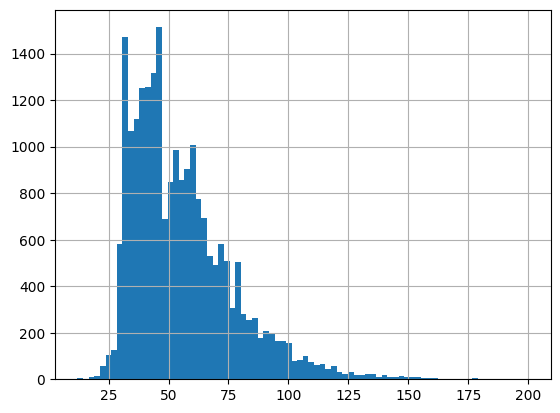

In [65]:
data['total_area'].hist(bins=80); #Строим гистограмму распределения общей площади квартир

Основная часть квартир имеет площадь менее 100 м2. Есть хвост из квартир с большей площадью. Вероятно, это многокомнатные квартиры и пентхаусы.

In [66]:
(
    data[data['total_area'] > 100]
    .pivot_table(index='rooms', values='total_area', aggfunc=['median', 'count'])
)

,median,count
,total_area,total_area
rooms,,
1,106.90,7
2,110.20,54
3,111.15,466
4,116.00,392


От части мы правы: это многокомнатные квартиры.

Скорее всего, квартиры с площадью более 100 м2 можно считать выбросами. Построим диаграмму межквартильного размаха.

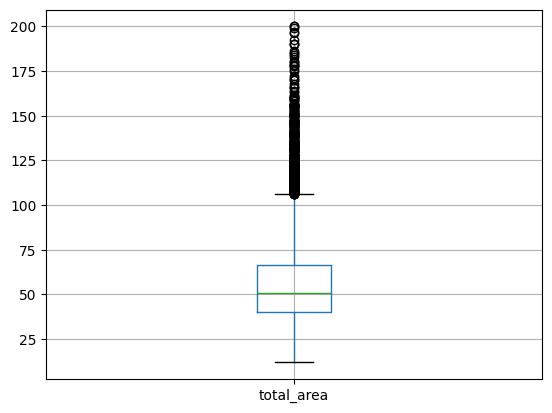

In [67]:
data.boxplot('total_area');

Действительно, все квартиры площадью больше 100 м2 - редкость. 

In [68]:
# Найдем медианную площадь квартир
data['total_area'].median()

51.0

Медианная площадь продаваемых квартир находится на уровне 51 м2.

***Жилая площадь***

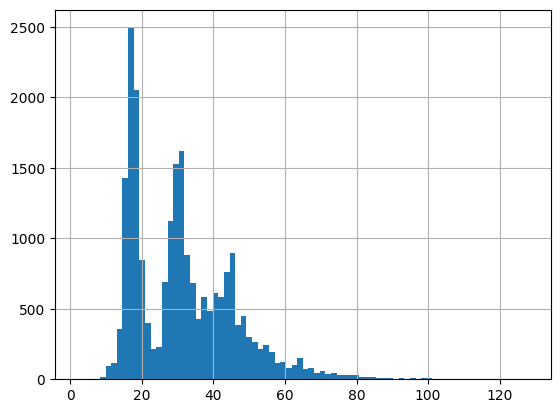

In [69]:
data['living_area'].hist(bins=80); #Строим гистограмму распределения жилой площади квартир

В основном продают квартиры с жилой площадью менее 50 м2. Построим диаграмму межквартильного размаха.

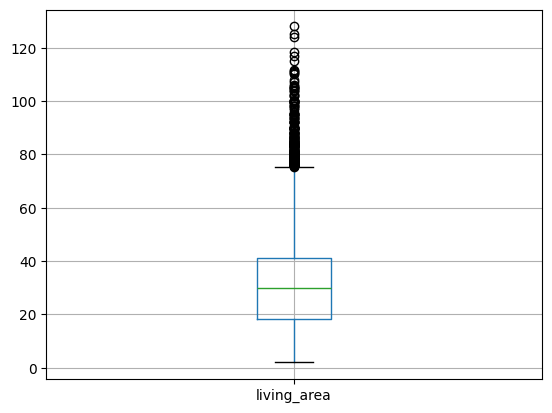

In [70]:
data.boxplot('living_area');

Выбросами можно считать квартиры с жил. площадью больше 75 м2. Медиана находится на уровне 30 м2.

***Площадь кухни***

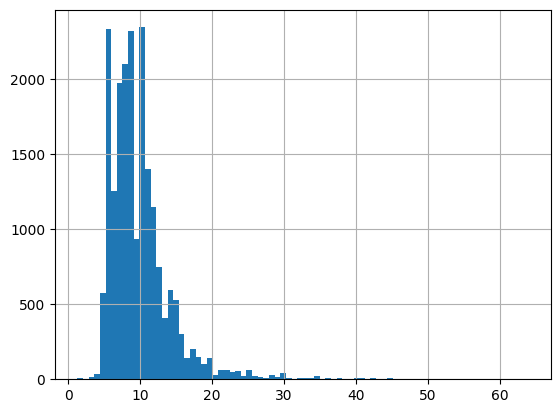

In [71]:
data['kitchen_area'].hist(bins=80); #Строим гистограмму распределения площади кухонь

Большая часть квартир имеет площадь кухни менее 20 м2. Посмотрим межквартильный размах.

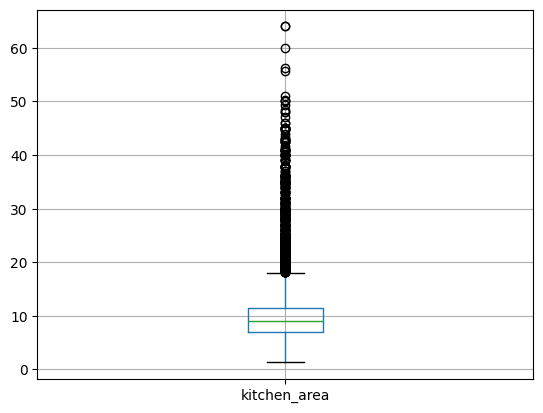

In [72]:
data.boxplot('kitchen_area');

Действительно, квартиры с площадью кухни более 20 м2 можно считать выбросами. Медиана находится на уровне 10 м2.

***Цена объекта***

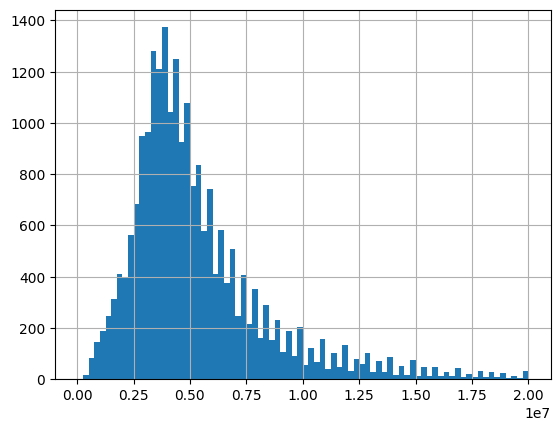

In [73]:
data['last_price'].hist(bins=80); #Строим гистограмму распределения цен на квартиры

В основном квартиры продают по ценам ниже 10 млн руб. Посмотрим межквартильный размах.

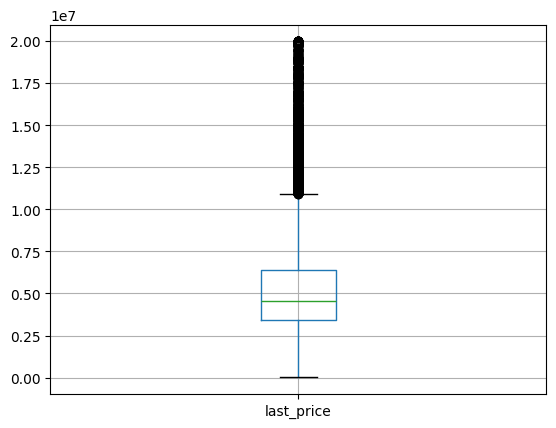

In [74]:
data.boxplot('last_price');

Видно, что в основном продают квартиры до 10 млн руб. Медиана составляет порядка 5 млн руб. Это уже больше похоже на правду.

***Количество комнат***

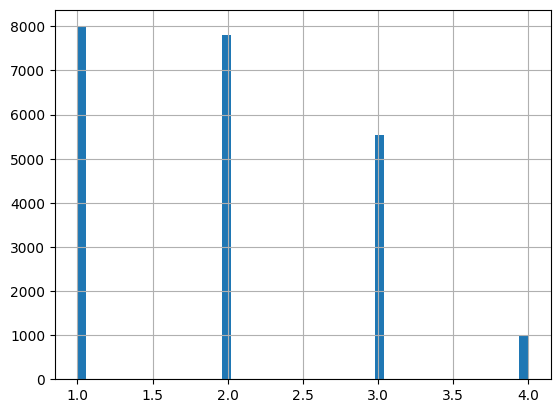

In [75]:
data['rooms'].hist(bins=50); #Строим гистограмму распределения количества комнат

По большей части продают 1 - 3 комнатные квартиры. Проанализируем межквартильный размах.

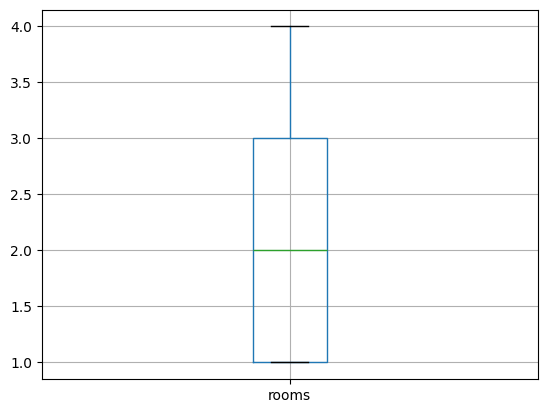

In [76]:
data.boxplot('rooms');

Действительно, 1 - 3 комнатные квартиры наиболее популярны. Квартиры с 5 и более комнатами можно считать выбросами.

***Высота потолков***

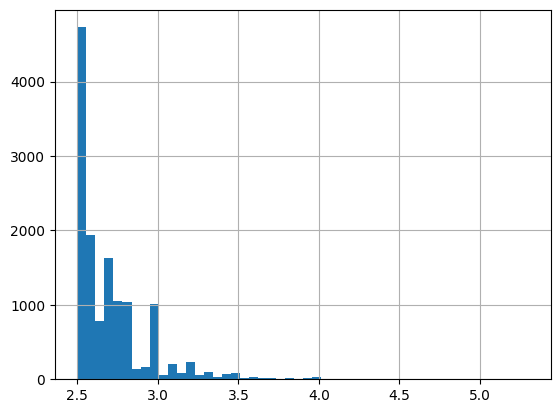

In [77]:
data['ceiling_height'].hist(bins=50); #Строим гистограмму распределения высот потолков

Преобладают квартиры с потолками от 2 до 3 м.

***Этаж***

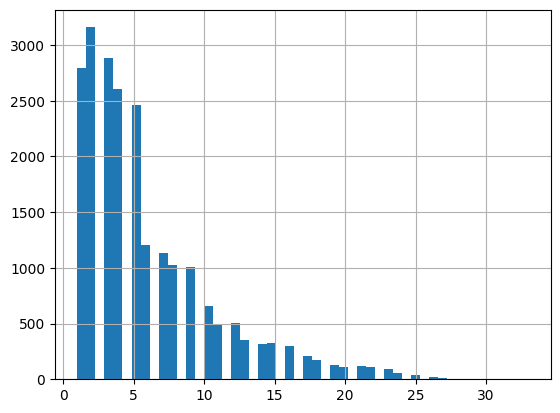

In [78]:
data['floor'].hist(bins=50); #Строим гистограмму распределения этажей, где расположены квартиры

Преимущественно продают квартиры на более низких этажах: не выше 6.

***Тип этажа квартиры***

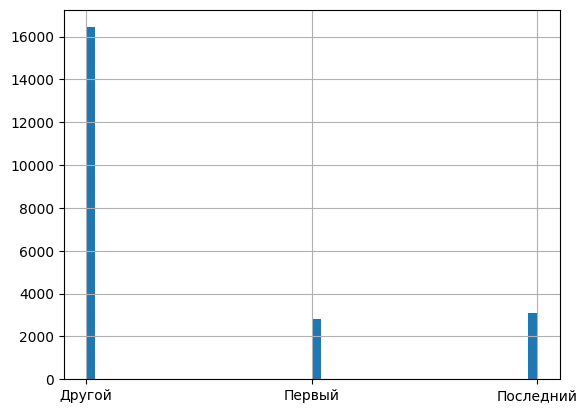

In [79]:
data['floor_type'].hist(bins=50); #Строим гистограмму распределения типов этажей квартир

Квартир на 1 и последнем этажах сопоставимое количество. В основном продают на этажах от 2 до предпоследнего.

***Общее количество этажей в доме***

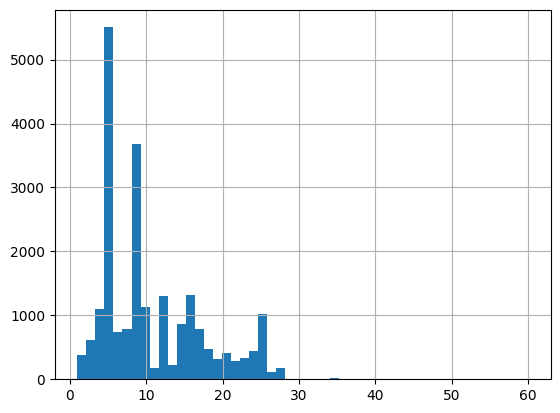

In [80]:
data['floors_total'].hist(bins=50); #Строим гистограмму распределения общего количества этажей в доме

Преобладают квартиры в домах не выше 10 этажей. Посмотрим межквартильный размах.

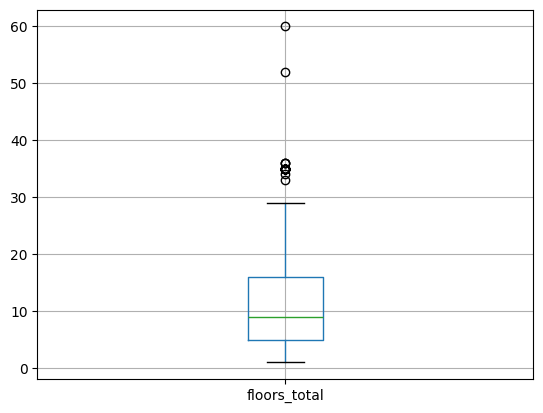

In [81]:
data.boxplot('floors_total');

Видно, что медиана близка к 10 этажам. Квартиры в домах выше 30 этажей можно отнести к выбросам.

***Расстояние до центра города***

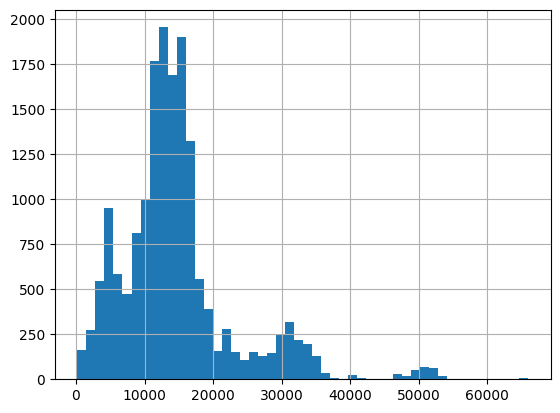

In [82]:
data['cityCenters_nearest'].hist(bins=50); #Строим гистограмму распределения расстояний до центра города

Преобладают квартиры, находящиеся не более чем в 20 км от центра города.

***Расстояние до ближайшего аэропорта***

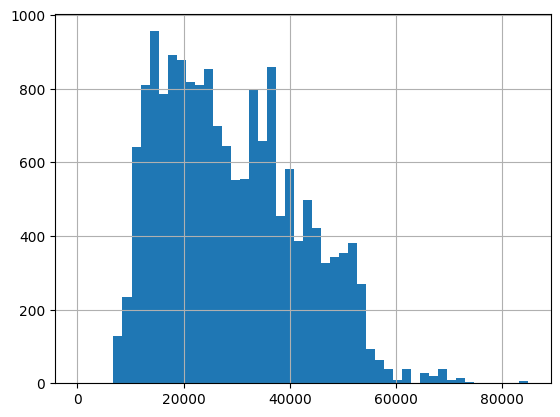

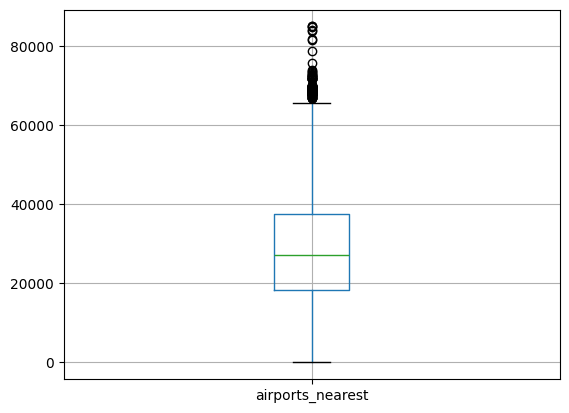

In [83]:
data['airports_nearest'].hist(bins=50) #Строим гистограмму распределения расстояний до ближайшего аэропорта
plt.show()
data.boxplot('airports_nearest') # Строим диаграмму межквартильного размаха
plt.show()

Большинство квартир находятся не более чем в 60 км от ближайшего аэропорта. Медиана составляет порядка 30 км.

***Расстояние до ближайшего парка***

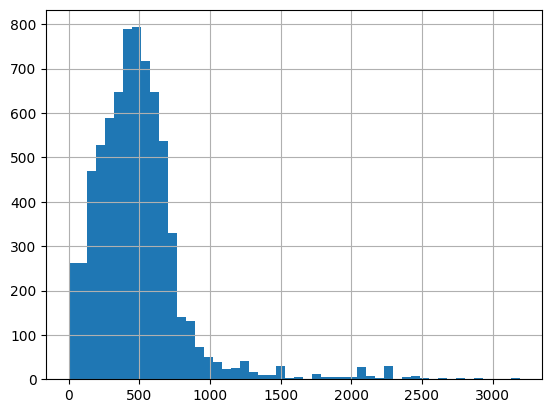

In [84]:
data['parks_nearest'].hist(bins=50); #Строим гистограмму распределения расстояний до ближайшего парка

Видим, что в большинстве случаев парки находятся не дальше 1 км от квартир.

***День и месяц публикации***

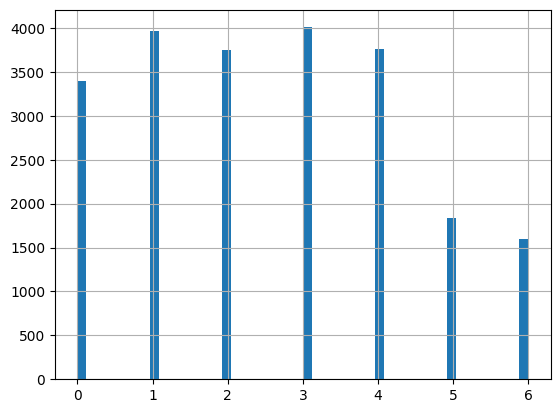

In [85]:
data['first_exposition_day_of_week'].hist(bins=50); #Строим гистограмму распределения дней недели публикации объявления

В основном объявления публиковали в будние дни.

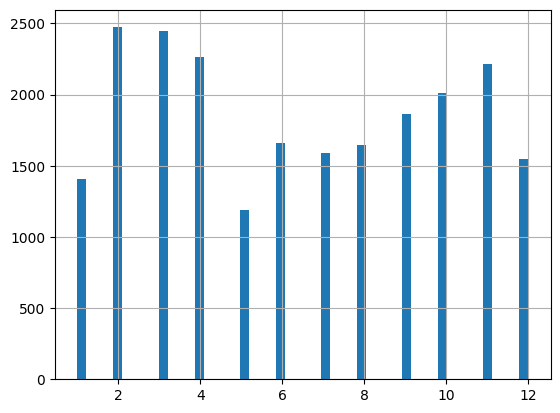

In [86]:
data['first_exposition_month'].hist(bins=50); #Строим гистограмму распределения месяцев публикации объявления

Наиболее активно публиковали объявления с февраля по апрель, а также с сентября по ноябрь.

#### Анализ скорости продажи квартир <a class='anchor' id='selling_speed'></a>

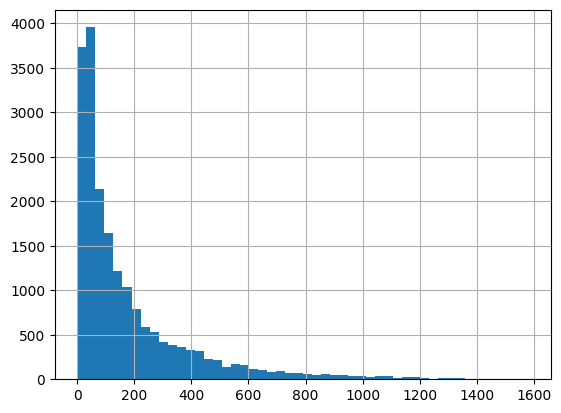

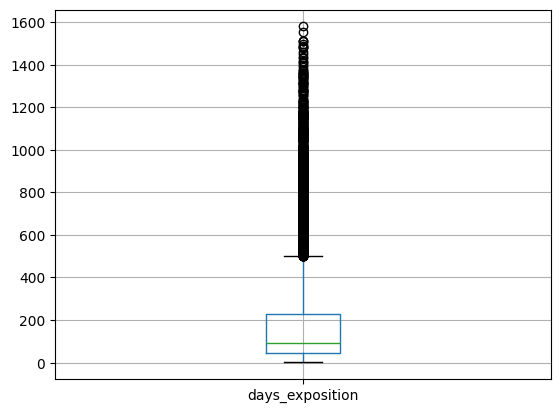

In [87]:
data['days_exposition'].hist(bins=50) #Строим гистограмму распределения числа дней существования объявления
plt.show()
data.boxplot('days_exposition') # Строим диаграмму межквартильного размаха
plt.show()

В основном объявления закрывали в течение 500 дней. Посмотрим на медиану и среднее.

In [88]:
print(f"Медиана равна {data['days_exposition'].median()}")
print(f"Среднее равно {data['days_exposition'].mean()}")

Медиана равна 94.0
Среднее равно 177.41142886534308


Среднее значение сильно завышено из-за выбросов. Медианное время продажи квартир составило 94 дней.

Посчитаем значения 1 и 3 квартилей. 

In [89]:
data['days_exposition'].quantile([0.25, 0.75])

0.25     44.0
0.75    226.0
Name: days_exposition, dtype: float64

К очень быстрым можно отнести продажи в течение 44 дней. К наиболее долгим - продажа более чем за 226 дня.

#### Факторы, влияющие на цену квартиры <a class='anchor' id='price_factors'></a>

In [90]:
# Создадим отдельный датасет из интересующих столбцов
price_regulation = data[
    ['last_price', 
     'total_area', 
     'living_area', 
     'kitchen_area', 
     'rooms' 
     ]
]
# Посмотрим на общую картину взаимосвязей цены с другими параметрами с использованием корреляционной матрицы
price_regulation.corr()

,last_price,total_area,living_area,kitchen_area,rooms
last_price,1.000000,0.763437,0.617529,0.574143,0.463443
total_area,0.763437,1.000000,0.898950,0.527369,0.772302
living_area,0.617529,0.898950,1.000000,0.241260,0.884471
kitchen_area,0.574143,0.527369,0.241260,1.000000,0.123380
rooms,0.463443,0.772302,0.884471,0.123380,1.000000


Проанализируем также диаграммы рассеяния.

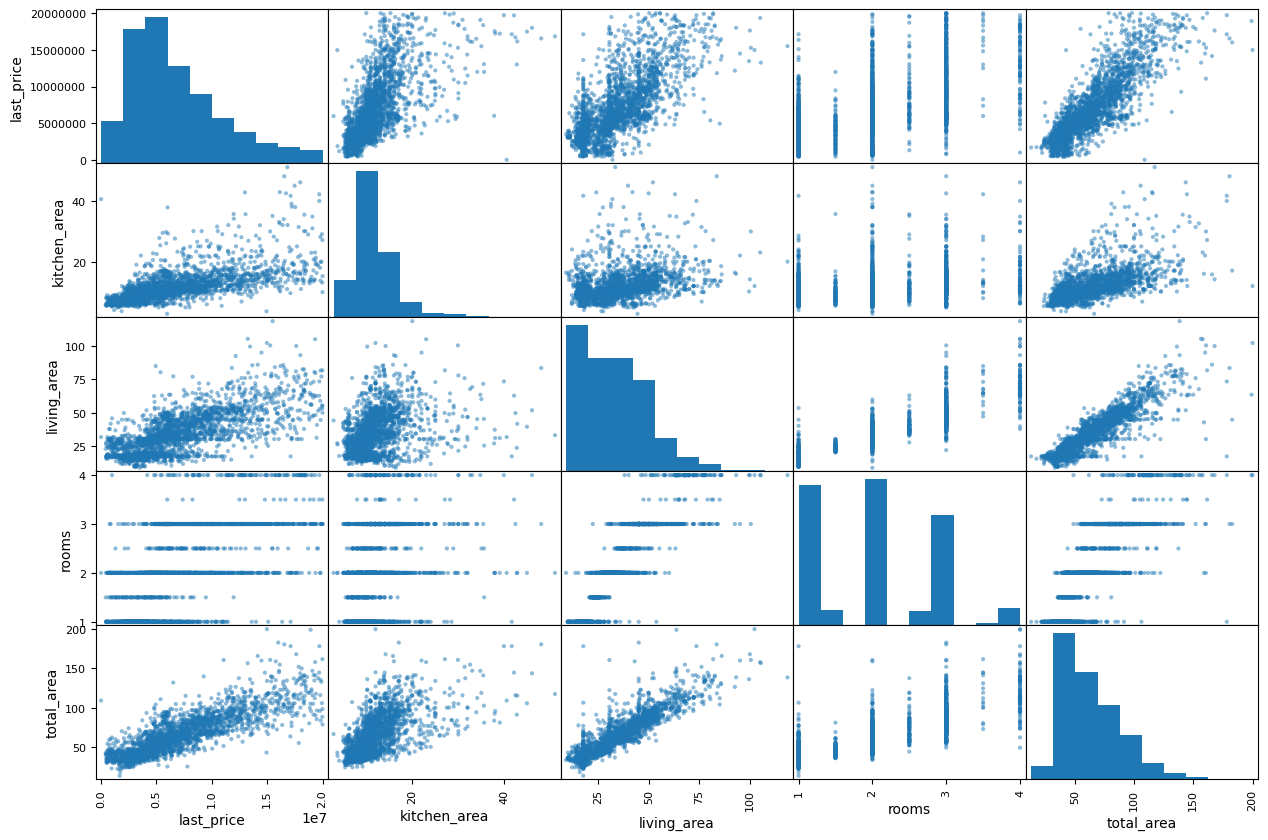

In [91]:
pd.plotting.scatter_matrix((price_regulation
 .pivot_table(index='last_price', values=['total_area', 'living_area', 'kitchen_area', 'rooms'], aggfunc=('median'))
).reset_index(), figsize=(15,10));

Отдельно рассмотрим влияние типа этажа на цену.

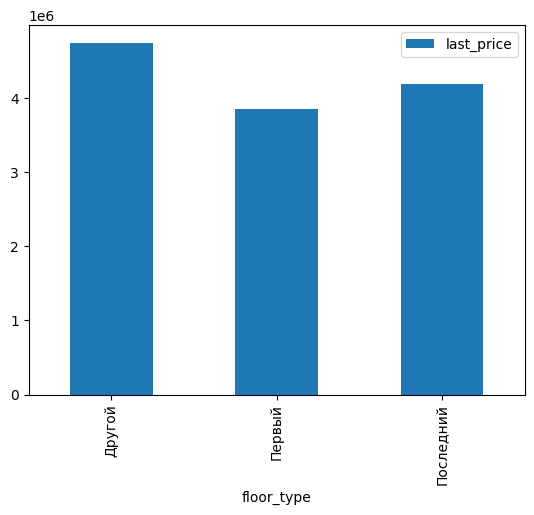

In [92]:
(data
 .pivot_table(index='floor_type', values='last_price', aggfunc='median')
 .reset_index()
 .plot(y='last_price', x='floor_type', kind='bar')
)
plt.show()

Видим, что основными факторами, положительно коррелирующими с ценой квартиры, являются общая и жилая площадь, а также площадь кухни. Есть чуть более слабая положительная корреляция с количеством комнат. А вот время, когда опубликовали объявление, не влияет на цену квартиры.

Квартиры на 1 этаже наиболее дешевые - меньше 4 млн руб. в среднем. Квартиры на последнем этаже несильно отличаются - около 4.3 млн руб. Остальные квартиры продают подороже - около 5 млн руб. в среднем.

**Построим столбчатые диаграммы для изучения влияния дня недели, месяца и года публикации объявления на цену квартир**

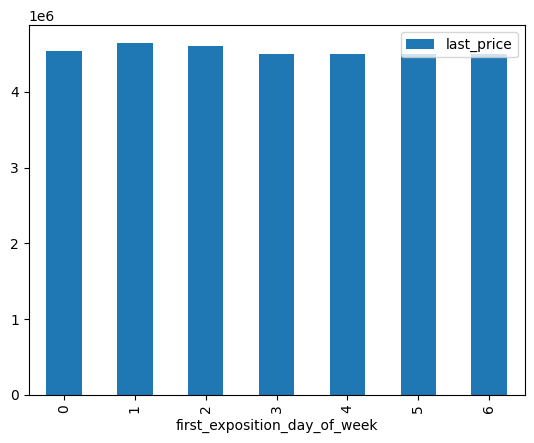

In [93]:
# Анализируем влияние дня недели публикации объявления на цену квартир
(data
 .pivot_table(index='first_exposition_day_of_week', values='last_price', aggfunc='median')
 .reset_index()
 .plot(y='last_price', x='first_exposition_day_of_week', kind='bar')
)
plt.show()

Видим, что день недели публикации объявления не влияет на медианную цену квартир.

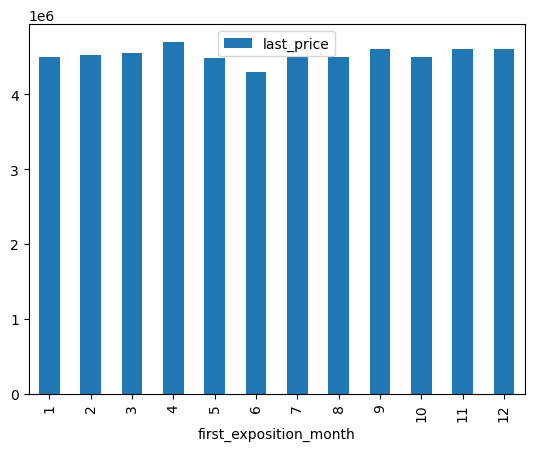

In [94]:
# Анализируем влияние месяца публикации объявления на цену квартир
(data
 .pivot_table(index='first_exposition_month', values='last_price', aggfunc='median')
 .reset_index()
 .plot(y='last_price', x='first_exposition_month', kind='bar')
)
plt.show()

Месяц публикации объявления также несильно влияет на цену квартиры. Отметим только, что для объявлений, опубликованных в июне, характерна наиболее низкая цена, по сравнению с другими месяцами.

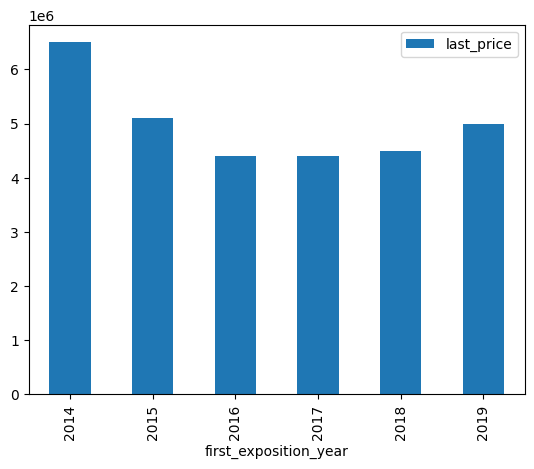

In [95]:
# Анализируем влияние года публикации объявления на цену квартир
(data
 .pivot_table(index='first_exposition_year', values='last_price', aggfunc='median')
 .reset_index()
 .plot(y='last_price', x='first_exposition_year', kind='bar')
)
plt.show()

**Год публикации** - вот, что влияет на цену квартиры. Максимальные медианные цены выше 6 млн руб. зафиксированы в 2014 г. Данный факт может быть связан с кризисом в России, наступившем в этом году. Далее наблюдался спад до уровня 4 млн руб. в 2016 г., стогнация до 2018 г. и небольшое повышение в 2019 г. до медианы в 5 млн руб.

#### Цена квадратного метра в разных населенных пунктах <a class='anchor' id='price_per_m2_in_different_places'></a>

In [96]:
# Делаем сводную таблицу медианных цен квадратного метра по населенным пунктам
area_rating = data.pivot_table(index='locality_name', values='price_per_area', aggfunc=['count', 'median']).reset_index()
# Переименовываем названия столбцов
area_rating.columns = ['Населенный пункт', 'Количество объявлений', 'Цена квадратного метра']
# Сортируем по убыванию количества объявлений и выбираем топ-10 населенных пунктов по количеству объявлений
top_10_area_rating = area_rating.sort_values('Количество объявлений', ascending=False).head(10)
# Сортируем по уменьшению цен квадратного метра и выводим топ-10 населенных пунктов
top_10_area_rating.sort_values('Цена квадратного метра', ascending=False)

,Населенный пункт,Количество объявлений,Цена квадратного метра
33,Санкт-Петербург,14556,103636.363636
32,Пушкин,353,99706.744868
17,Кудрово,450,95435.612635
268,посёлок Парголово,320,91984.436588
22,Мурино,555,84876.543210
287,посёлок Шушары,432,76747.967480
13,Колпино,333,74733.096085
6,Гатчина,302,67671.510409
3,Всеволожск,387,65686.274510
4,Выборг,234,58357.385977


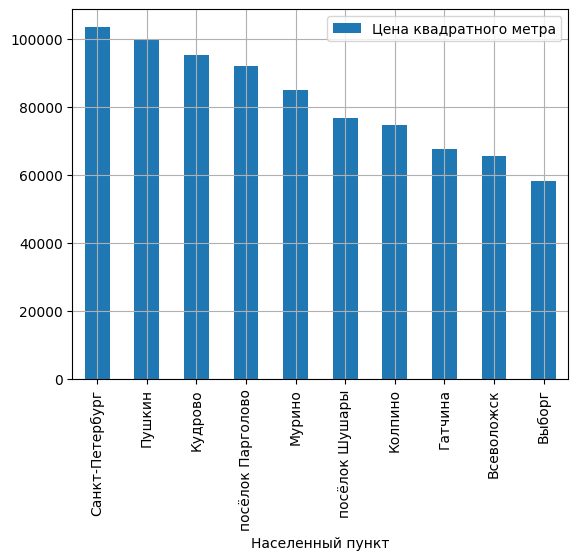

In [97]:
(
    top_10_area_rating
    .sort_values('Цена квадратного метра', ascending=False)
    .plot(y='Цена квадратного метра', x='Населенный пункт', kind='bar', grid=True)
);

Наиболее высокая цена квадратного метра характерна для квартир в Санкт-Петербурге, Пушкине и Кудрово: более 95 тыс. руб./м2.

В 1.5 раза дешевле квартиры в Гатчине, Всеволожске и Выборге: 58 - 67 тыс. руб./м2.

#### Влияние удаленности от центра на стоимость квартир <a class='anchor' id='centre_distance_influence'></a>

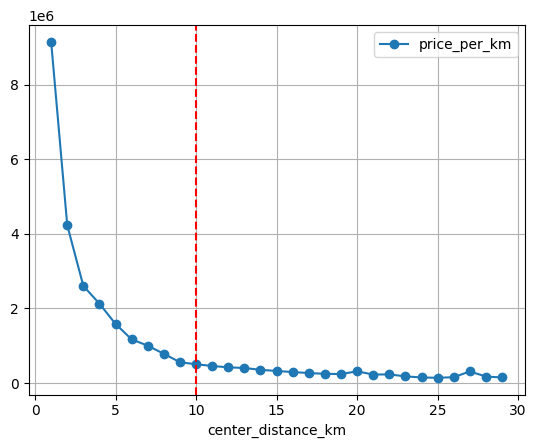

In [98]:
# Сделаем срез по квартирам, находящимся в Санкт-Петербурге
spb = data[data['locality_name'] == 'Санкт-Петербург']
# Для каждой квартиры определим стоимость 1 км до центра
spb['price_per_km'] = spb['last_price'] / spb['center_distance_km']
# Проанализируем медианную стоимость 1 км в зависимости от расстояния до центра
(
    spb
    .pivot_table(index='center_distance_km', values='price_per_km', aggfunc='median')
    .reset_index()
    .plot(y='price_per_km', x='center_distance_km', style='o-', grid=True)
)
plt.axvline(x=10, ymin=0, ymax=11000000, color='red', linestyle='dashed');

Отметим, что чем ближе квартира к центру, тем выше стоимость 1 км. Резкий скачок наблюдается для квартир, находящихся не дальше 10 км от центра.

Посмотрим на изменение цены 1 квадратного метра в зависимости от расстояния до центра.

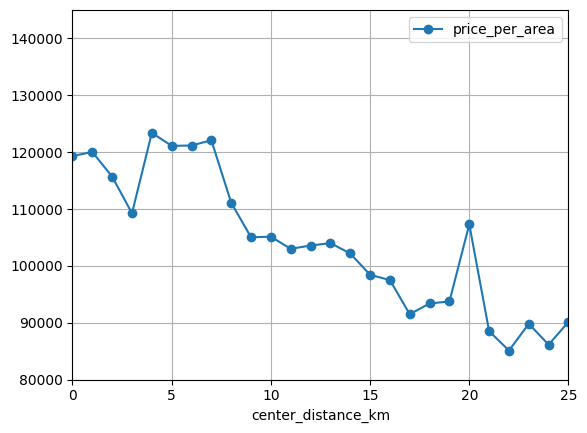

In [99]:
(
    spb
    .pivot_table(index='center_distance_km', values='price_per_area', aggfunc='median')
    .reset_index()
    .plot(y='price_per_area', x='center_distance_km', style='o-', grid=True, ylim=(80000, 145000), xlim=(0, 25))
);

Цена квадратного метра также увеличивается по мере приближения к центру города. 

### Общий вывод <a class='anchor' id='conclusion'></a>

В настоящей работе проанализировано влияние различных факторов на цены квартир в Санкт-Петербурге и Ленинградской области, а также динамика продаж. По результатам анализа можно сделать следующие выводы:
- Наибольшее влияние на цену квартиры оказывают общая и жилая площадь, количество комнат, а также площадь кухни. При этом также стоит отметить, что чем ближе квартира к центру города, тем выше ее стоимость. Так, для квартир, находящихся не дальше 10 км от центра характерен скачок цены 1 км с 1 млн руб./км до 10 млн руб./км;
- Год публикации - вот, что еще влияет на цену квартиры. Максимальные медианные цены выше 6 млн руб. зафиксированы в 2014 г. Данный факт может быть связан с кризисом в России, наступившем в этом году. Далее наблюдался спад до уровня 4 млн руб. в 2016 г., стогнация до 2018 г. и небольшое повышение в 2019 г. до медианы в 5 млн руб.
- Наиболее высокая цена квадратного метра характерна для квартир в Санкт-Петербурге, Пушкине и Кудрово: более 95 тыс. руб./м2. В 1.5 раза дешевле квартиры в Гатчине, Всеволожске и Выборге: 58 - 67 тыс. руб./м2;
- Наиболее дешевыми являются квартиры, находящиеся на 1 этаже, - ниже 4 млн руб. в среднем. Квартиры на последнем этаже несильно отличаются - около 4.3 млн руб. Остальные квартиры продают подороже - около 5 млн руб. в среднем;
- Квартиры продаются с разной скоростью. К очень быстрым можно отнести продажи в течение 44 дней. К наиболее долгим - продажа более чем за 226 дней;


- При анализе данных в разных столбцах выявлены следующие тренды:
    - В основном объявления публиковали в будние дни. Наиболее активно публиковали объявления с февраля по апрель, а также с сентября по ноябрь;
    - Видим, что в большинстве случаев парки находятся не дальше 1 км от квартир;
    - Большинство квартир находятся не более чем в 60 км от ближайшего аэропорта. Медиана составляет порядка 30 км;
    - Преобладают квартиры, находящиеся не более чем в 20 км от центра города;
    - Преобладают квартиры в домах не выше 10 этажей;
    - Квартир на 1 и последнем этажах сопоставимое количество. В основном продают на этажах от 2 до предпоследнего;
    - Преобладают квартиры с потолками от 2 до 3 м;
    - По большей части продают 1 - 3 комнатные квартиры;
    - В основном продают квартиры до 10 млн руб. Медиана составляет порядка 5 млн руб.;
    - Большая часть квартир имеет площадь кухни менее 20 м2;
    - В основном продают квартиры с жилой площадью менее 50 м2;
    - Медианная общая площадь продаваемых квартир находится на уровне 51 м2;


- На этапе предобработки данных выявлены следующие аномалии:
    - Квартиры с потолками высотой более 20 м. Такие цифры отнесены к опечаткам и уменьшены в 10 раз. Квартиры с высотой потолков от 8 до 20 м были удалены из датасета. Квартиры со слишком низкими потолками (менее 2.5 м), не удовлетворяющие ГОСТ, тоже удалены;
    - Квартиры, где площадь кухни и жилая площадь превышают общую площадь, убраны из датасета во избежание искажения результатов анализа;
    - Есть 2057 квартир, где число балконов превышает число комнат. Есть квартиры, где комнат вообще нет и есть 1 балкон. Количество комнат в таких квартирах, действительно, равно нулю. При этом указана жилая площадь. Причем имеют место быть случаи, когда в квартире нет комнат и это не студия. Такие квартиры были удалены из датасета. Квартиры, где 2 - 5 балконов, а комнат меньше, было решено оставить в датасете, так как число балконов не являлось предметом анализа и не влияло на выводы;
    - Квартиры с общей площадью более 200 м2;
    - Квартиры стоимостью выше 20 млн руб.;
    - Квартиры более чем с 4 комнатами и без комнат вовсе;
 
- В данных присутствовали 47 неявных дубликатов названий населенных пунктов. Все они были успешно приведены к одному виду написания;
- Данные в столбце с датами публикации имели тип данных `object`. Их перевели в datetime. Также столбец is_apartment, где должны храниться данные булева типа, имел тип данных object. Этот столбец привели к типу `bool`. 
- В данных присутствовали пропуски в разных столбцах. Удалось заполнить пустые ячейки в следующих случаях:
    * Пропуски в столбцах с данными о прудах и парках в радиусе 3 км заполнены нулями, так как парков и прудов поблизости просто нет;
    * Пропуски в столбце с данными о том, является ли квартира апартаментами, заполнены значениями `False`, так как такие квартиры апартаментами не являются и это забыли указать;
    * Пропуски в столбцах с данными о количестве балконов заполнены нулями, так как в этих квартирах нет балконов;
    * Пропуски в столбцах с данными о жилой площади заполнены медианными значениями жилой площади для квартир с таким же числом комнат.